<a href="https://colab.research.google.com/github/Offliners/HTML_2021Fall/blob/main/Final%20Project/final_project_correct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Directory**

```
data_dir
    ├── data
    │   ├── Test_IDs.csv
    │   ├── ...
    │   ├── status.csv
    ├── statistics
    │   ├── Churn Category_stat.png
    │   ├── ...
    │   ├── miss rate_stat.png
```

# **Display information of GPU**

In [1]:
!nvidia-smi

Wed Jan 19 14:02:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Download Some Package**

In [2]:
!pip install lime

     |████████████████████████████████| 275 kB 4.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=cc462c7f6bfc606100a21fc85350c17be9606316a8d458fde87deffdd0ff3e53
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


# **Download Dataset**

In [3]:
!mkdir "./data"
!mkdir "./statistics"
!gdown --id 1X5yz7QLAu4nttnCea4ALf6alae6Clv_o --output "./data/dataset.zip"
!unzip -q "./data/dataset.zip" -d "./data"
!rm "./data/dataset.zip"

Downloading...
From: https://drive.google.com/uc?id=1X5yz7QLAu4nttnCea4ALf6alae6Clv_o
To: /content/data/dataset.zip
100% 660k/660k [00:00<00:00, 90.8MB/s]


# **Import Some Packages**

In [94]:
import time
import numpy as np
import pandas as pd
from glob import glob
from collections import Counter
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

# Fix Imbalance Dataset
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE, SMOTEN

# SVM
from sklearn.svm import SVC

# DNN
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

# XGBoost
from xgboost import XGBClassifier

# Model Interpretability
import lime
from lime import lime_tabular

# **Set a Random Seed**

In [95]:
# Set a random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# **CSV Files Combination**

In [96]:
train_path = './data/Train_IDs.csv'  # path to training data
test_path = './data/Test_IDs.csv'    # path to testing data

files = glob('./data/*.csv')
data_csv = []
data_csv.append(train_path)
for csv in files:
    if ('IDs' not in csv) and ('sample' not in csv) and ('population' not in csv) and ('result' not in csv):
        data_csv.append(csv)

data_csv.remove('./data/status.csv')
data_csv.append('./data/status.csv')

print(data_csv)
df_list = [pd.read_csv(file) for file in data_csv]

['./data/Train_IDs.csv', './data/location.csv', './data/satisfaction.csv', './data/services.csv', './data/demographics.csv', './data/status.csv']


In [97]:
result_total = df_list[0]
for df in df_list[1:]:
    result_total = pd.merge(result_total, df, how='outer', on='Customer ID')

result_total.to_csv('./data/result_total.csv') # Save combined all result to result_total.csv

In [98]:
# There are 7043 total customer data
print(result_total)

     Customer ID  Count_x  ... Number of Dependents Churn Category
0     0650-BWOZN      NaN  ...                  0.0     Competitor
1     0562-FGDCR      1.0  ...                  0.0     Competitor
2     6688-UZPWD      1.0  ...                  NaN       No Churn
3     2905-KFQUV      1.0  ...                  0.0     Competitor
4     9720-JJJOR      1.0  ...                  0.0       No Churn
...          ...      ...  ...                  ...            ...
7038  8406-LNMHF      NaN  ...                  3.0            NaN
7039  1926-QUZNN      NaN  ...                  NaN            NaN
7040  5356-RHIPP      NaN  ...                  2.0            NaN
7041  4893-GYUJU      NaN  ...                  0.0            NaN
7042  3426-NIYYL      NaN  ...                  2.0            NaN

[7043 rows x 48 columns]


In [99]:
# Train_IDs has 5634 customer data
result_train_total = df_list[0]
for df in df_list[1:]:
    result_train_total = pd.merge(result_train_total, df, how='left', on='Customer ID')

print(result_train_total)

     Customer ID  Count_x  ... Number of Dependents Churn Category
0     0650-BWOZN      NaN  ...                  0.0     Competitor
1     0562-FGDCR      1.0  ...                  0.0     Competitor
2     6688-UZPWD      1.0  ...                  NaN       No Churn
3     2905-KFQUV      1.0  ...                  0.0     Competitor
4     9720-JJJOR      1.0  ...                  0.0       No Churn
...          ...      ...  ...                  ...            ...
5629  1178-PZGAB      NaN  ...                  0.0            NaN
5630  4806-KEXQR      1.0  ...                  0.0            NaN
5631  8809-RIHDD      NaN  ...                  2.0       No Churn
5632  6663-JOCQO      NaN  ...                  3.0       No Churn
5633  7010-ZMVBF      1.0  ...                  0.0       No Churn

[5634 rows x 48 columns]


In [100]:
# Train_IDs has 4226 customer data with label
result_train = df_list[0]
for df in df_list[1:]:
    result_train = pd.merge(result_train, df, how='right', on='Customer ID')

print(result_train)

     Customer ID  Count_x  ... Number of Dependents Churn Category
0     0650-BWOZN      NaN  ...                  0.0     Competitor
1     0562-FGDCR      1.0  ...                  0.0     Competitor
2     6688-UZPWD      1.0  ...                  NaN       No Churn
3     2905-KFQUV      1.0  ...                  0.0     Competitor
4     9720-JJJOR      NaN  ...                  0.0       No Churn
...          ...      ...  ...                  ...            ...
4221  3313-QKNKB      NaN  ...                  NaN       No Churn
4222  8668-KNZTI      NaN  ...                  NaN       No Churn
4223  8809-RIHDD      NaN  ...                  2.0       No Churn
4224  6663-JOCQO      NaN  ...                  3.0       No Churn
4225  7010-ZMVBF      1.0  ...                  0.0       No Churn

[4226 rows x 48 columns]


In [101]:
# Train_IDs has 1408 customer data without label
result_train_miss = df_list[0]
for df in df_list[1:]:
    result_train_miss = pd.merge(result_train_miss, df, how='left', on='Customer ID')

result_train_miss = result_train_miss[result_train_miss['Churn Category'].isna()]

print(result_train_miss)

     Customer ID  Count_x  ... Number of Dependents Churn Category
6     0394-YONDK      1.0  ...                  NaN            NaN
7     0396-HUJBP      NaN  ...                  0.0            NaN
11    0684-AOSIH      1.0  ...                  2.0            NaN
14    1679-JRFBR      1.0  ...                  0.0            NaN
18    5533-NHFRF      1.0  ...                  0.0            NaN
...          ...      ...  ...                  ...            ...
5603  6330-JKLPC      1.0  ...                  NaN            NaN
5618  4549-ZDQYY      1.0  ...                  0.0            NaN
5622  9127-QRZMH      1.0  ...                  0.0            NaN
5629  1178-PZGAB      NaN  ...                  0.0            NaN
5630  4806-KEXQR      1.0  ...                  0.0            NaN

[1408 rows x 48 columns]


In [102]:
# Test_Ids has 1409 customer data
df_test = pd.read_csv(test_path)
result_test = df_test
for df in df_list[1:]:
    result_test = pd.merge(result_test, df, how='left', on='Customer ID')

print(result_test)

     Customer ID  Count_x  ... Number of Dependents Churn Category
0     9938-EKRGF      1.0  ...                  0.0            NaN
1     7379-POKDZ      1.0  ...                  0.0            NaN
2     0654-HMSHN      1.0  ...                  NaN            NaN
3     2045-BMBTJ      NaN  ...                  3.0            NaN
4     0701-TJSEF      1.0  ...                  0.0            NaN
...          ...      ...  ...                  ...            ...
1404  4587-VVTOX      1.0  ...                  NaN            NaN
1405  7716-YTYHG      1.0  ...                  0.0            NaN
1406  7649-PHJVR      NaN  ...                  0.0            NaN
1407  7855-DIWPO      1.0  ...                  3.0            NaN
1408  8197-BFWVU      1.0  ...                  NaN            NaN

[1409 rows x 48 columns]


In [103]:
print(result_total.dropna()) # Find customer with full data infomation
full_info = result_total.dropna()

     Customer ID  Count_x  ... Number of Dependents   Churn Category
666   0454-OKRCT      1.0  ...                  2.0         No Churn
678   1735-XMJVH      1.0  ...                  0.0         No Churn
1799  1245-HARPS      1.0  ...                  0.0  Dissatisfaction
2805  8445-DNBAE      1.0  ...                  0.0       Competitor
2883  8708-XPXHZ      1.0  ...                  0.0         No Churn
3062  9522-ZSINC      1.0  ...                  0.0         No Churn
4297  0836-SEYLU      1.0  ...                  0.0         No Churn
5146  7274-RTAPZ      1.0  ...                  1.0         No Churn

[8 rows x 48 columns]


In [104]:
result_cols = result_total.columns
print(result_cols)

Index(['Customer ID', 'Count_x', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Satisfaction Score', 'Count_y',
       'Quarter', 'Referred a Friend', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Count', 'Gender', 'Age', 'Under 30', 'Senior Citizen',
       'Married', 'Dependents', 'Number of Dependents', 'Churn Category'],
      dtype='object')


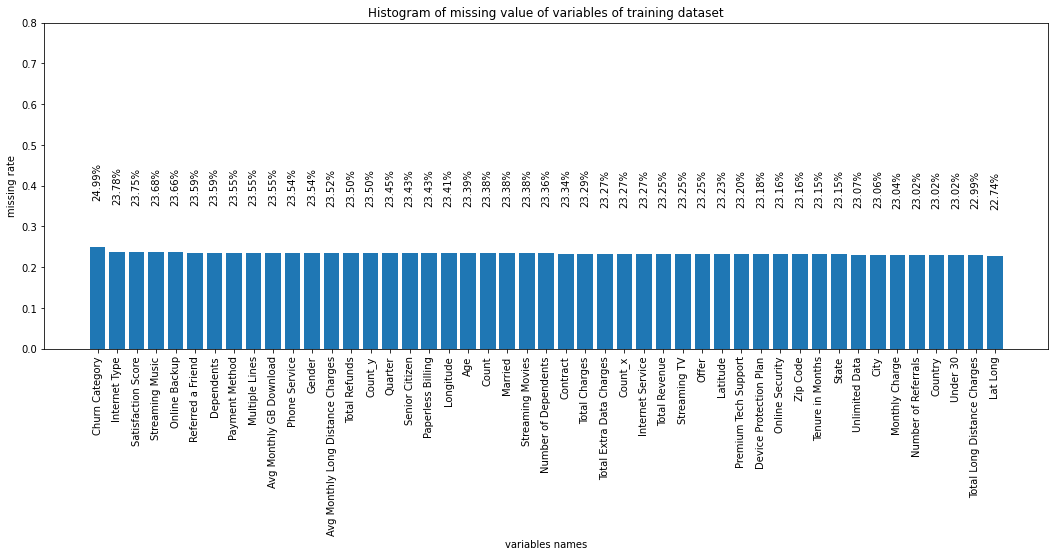

In [105]:
missing = result_train_total.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_train_total.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of training dataset')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 0.8])  
plt.savefig(f'./statistics/miss rate_train_stat.png')  
plt.show()
plt.close()

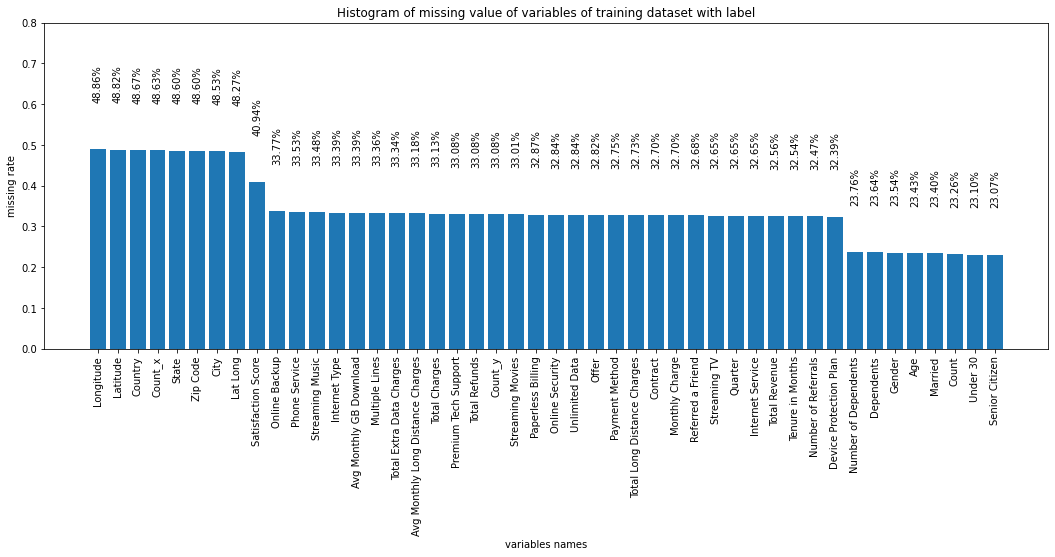

In [106]:
missing = result_train.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_train.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of training dataset with label')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 0.8])  
plt.savefig(f'./statistics/miss rate_train_stat.png')  
plt.show()
plt.close()

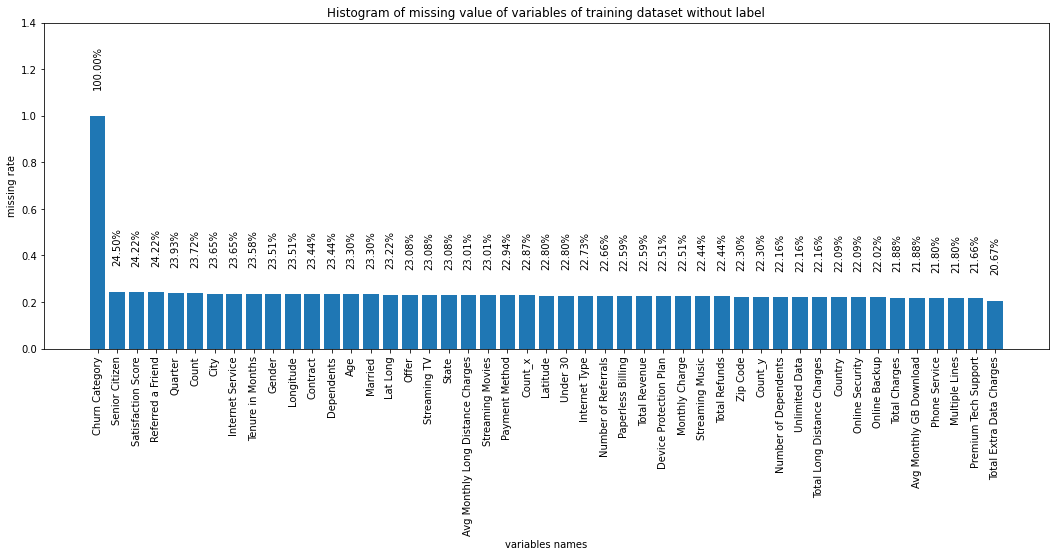

In [107]:
missing = result_train_miss.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_train_miss.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of training dataset without label')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 1.4])  
plt.savefig(f'./statistics/miss rate_train_stat.png')  
plt.show()
plt.close()

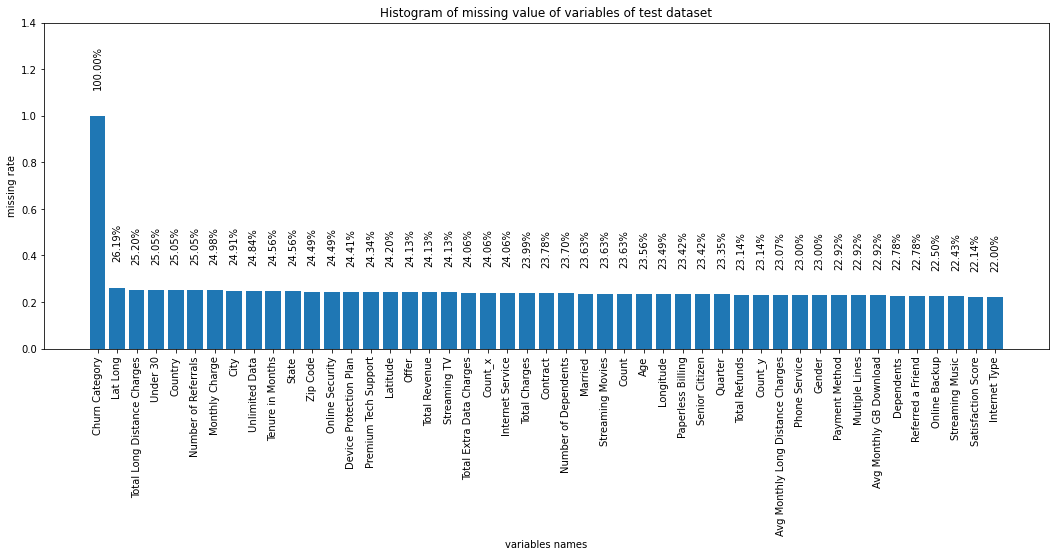

In [108]:
missing = result_test.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_test.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of test dataset')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 1.4])  
plt.savefig(f'./statistics/miss rate_test_stat.png')  
plt.show()
plt.close()

# **Statistics and Data Preprocessing**

In [109]:
result_train_total_copy = result_train_total.copy(deep=True)
result_train_copy = result_train.copy(deep=True)
result_train_miss_copy = result_train_miss.copy(deep=True)
result_test_copy = result_test.copy(deep=True)
full_info_copy = full_info.copy(deep=True)
def label_statistics(label):
    freq = result_train_total.groupby(label).size()

    names = [name for name, _ in freq.items()]
    names.append('Nan')
    counts = [count for _, count in freq.items()]
    counts.append(len(result_train[label]) - sum(counts))

    fig = plt.figure(figsize=(8, 6))
    x = np.arange(len(names))
    plt.bar(x, counts)
    plt.xticks(x, names, rotation=15)
    plt.title(f'Statistics of {label}')
    plt.savefig(f'./statistics/Statistics of {label}.png')
    print(f'Statistics of {label}.png saved')
    plt.close()

In [110]:
need_statistics_col = ['Churn Category', 'Satisfaction Score', 
       'Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Country', 'State', 'City', 'Quarter',
       'Referred a Friend', 'Number of Referrals', 'Offer',
       'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Zip Code']

# Replace NaN with the most frequent label
for need_col in need_statistics_col:
    label_statistics(need_col)

    # Encode target labels with value
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    oe.fit(result_train_copy[[need_col]])
    result_train_copy[need_col] = oe.transform(result_train_copy[[need_col]])
    full_info_copy[need_col] = oe.transform(full_info_copy[[need_col]])

    if need_col == 'Churn Category':
        encoder = oe.categories_[0]
        encoder_map = dict(zip(encoder, list(range(6))))
        continue

    result_train_miss_copy[need_col] = oe.transform(result_train_miss_copy[[need_col]])
    result_test_copy[need_col] = oe.transform(result_test_copy[[need_col]])

Statistics of Churn Category.png saved
Statistics of Satisfaction Score.png saved
Statistics of Gender.png saved
Statistics of Under 30.png saved
Statistics of Senior Citizen.png saved
Statistics of Married.png saved
Statistics of Dependents.png saved
Statistics of Number of Dependents.png saved
Statistics of Country.png saved
Statistics of State.png saved
Statistics of City.png saved
Statistics of Quarter.png saved
Statistics of Referred a Friend.png saved
Statistics of Number of Referrals.png saved
Statistics of Offer.png saved
Statistics of Phone Service.png saved
Statistics of Multiple Lines.png saved
Statistics of Internet Service.png saved
Statistics of Internet Type.png saved
Statistics of Online Security.png saved
Statistics of Online Backup.png saved
Statistics of Device Protection Plan.png saved
Statistics of Premium Tech Support.png saved
Statistics of Streaming TV.png saved
Statistics of Streaming Movies.png saved
Statistics of Streaming Music.png saved
Statistics of Unlimi

In [111]:
population = pd.read_csv('./data/population.csv')
population = population.drop('Zip Code', axis=1)
population.rename({'ID':'Zip Code'}, axis=1, inplace=True)
result_train_copy = pd.merge(result_train_copy, population, how='left', on='Zip Code')
result_train_miss_copy = pd.merge(result_train_miss_copy, population, how='left', on='Zip Code')
result_test_copy = pd.merge(result_test_copy, population, how='left', on='Zip Code')
full_info_copy = pd.merge(full_info_copy, population, how='left', on='Zip Code')

need_avg_col = [item for item in result_cols if item not in need_statistics_col]
need_avg_col.append('Population')

def data_imputation(train_dataset, miss_dataset, test_dataset, target, flag):
    if flag:
        # imputer = IterativeImputer(max_iter=2, initial_strategy='median', random_state=seed)
        # imputer = KNNImputer(n_neighbors=2, weights='distance')
        imputer = SimpleImputer(strategy='median')
    else:
        imputer = SimpleImputer(strategy='most_frequent')

    imputer.fit(train_dataset)
    train_dataset = imputer.transform(train_dataset)
    miss_dataset = imputer.transform(miss_dataset)
    test_dataset = imputer.transform(test_dataset)

    train_dataset = pd.DataFrame(train_dataset, columns=target)
    miss_dataset = pd.DataFrame(miss_dataset, columns=target)
    test_dataset = pd.DataFrame(test_dataset, columns=target)

    return train_dataset, miss_dataset, test_dataset

col_names = list(result_cols.values)
col_names.remove('Customer ID')
col_names.remove('Lat Long')
col_names.remove('Churn Category')
col_names.append('Population')

for label in col_names:
    if label in need_avg_col:
        flag = 1
    else:
        flag = 0
    
    target = [label, 'Churn Category']
    result_train_copy[target], result_train_miss_copy[target], result_test_copy[target] = \
    data_imputation(result_train_copy[target], result_train_miss_copy[target], result_test_copy[target], target, flag)

In [112]:
result_train_copy = result_train_copy.drop('Customer ID', axis=1)
result_train_copy = result_train_copy.drop('Lat Long', axis=1)
result_train_miss_copy = result_train_miss_copy.drop('Customer ID', axis=1)
result_train_miss_copy = result_train_miss_copy.drop('Lat Long', axis=1)
result_test_copy = result_test_copy.drop('Customer ID', axis=1)
result_test_copy = result_test_copy.drop('Lat Long', axis=1)
full_info_copy = full_info_copy.drop('Customer ID', axis=1)
full_info_copy = full_info_copy.drop('Lat Long', axis=1)

print(result_train_copy)

      Count_x  Country  State  ...  Number of Dependents  Churn Category  Population
0         1.0      0.0    0.0  ...                   0.0             1.0     22443.0
1         1.0      0.0    0.0  ...                   0.0             1.0     32899.0
2         1.0      0.0    0.0  ...                   0.0             3.0     52202.0
3         1.0      0.0    0.0  ...                   0.0             1.0     47453.0
4         1.0      0.0    0.0  ...                   0.0             3.0     22443.0
...       ...      ...    ...  ...                   ...             ...         ...
4221      1.0      0.0    0.0  ...                   0.0             3.0     22443.0
4222      1.0      0.0    0.0  ...                   0.0             3.0     22443.0
4223      1.0      0.0    0.0  ...                   2.0             3.0     22443.0
4224      1.0      0.0    0.0  ...                   3.0             3.0     22443.0
4225      1.0      0.0    0.0  ...                   0.0         

In [113]:
# Find the correlation of columns of full infomation data
full_cor_matrix = full_info_copy.corr().abs()
print(full_cor_matrix['Churn Category'])

Count_x                                   NaN
Country                                   NaN
State                                     NaN
City                                 0.269846
Zip Code                             0.446345
Latitude                             0.632094
Longitude                            0.385506
Satisfaction Score                   0.819689
Count_y                                   NaN
Quarter                                   NaN
Referred a Friend                    0.538816
Number of Referrals                  0.502206
Tenure in Months                     0.545119
Offer                                0.048002
Phone Service                        0.324617
Avg Monthly Long Distance Charges    0.361105
Multiple Lines                       0.203653
Internet Service                     0.311086
Internet Type                        0.464765
Avg Monthly GB Download              0.475511
Online Security                      0.203653
Online Backup                     

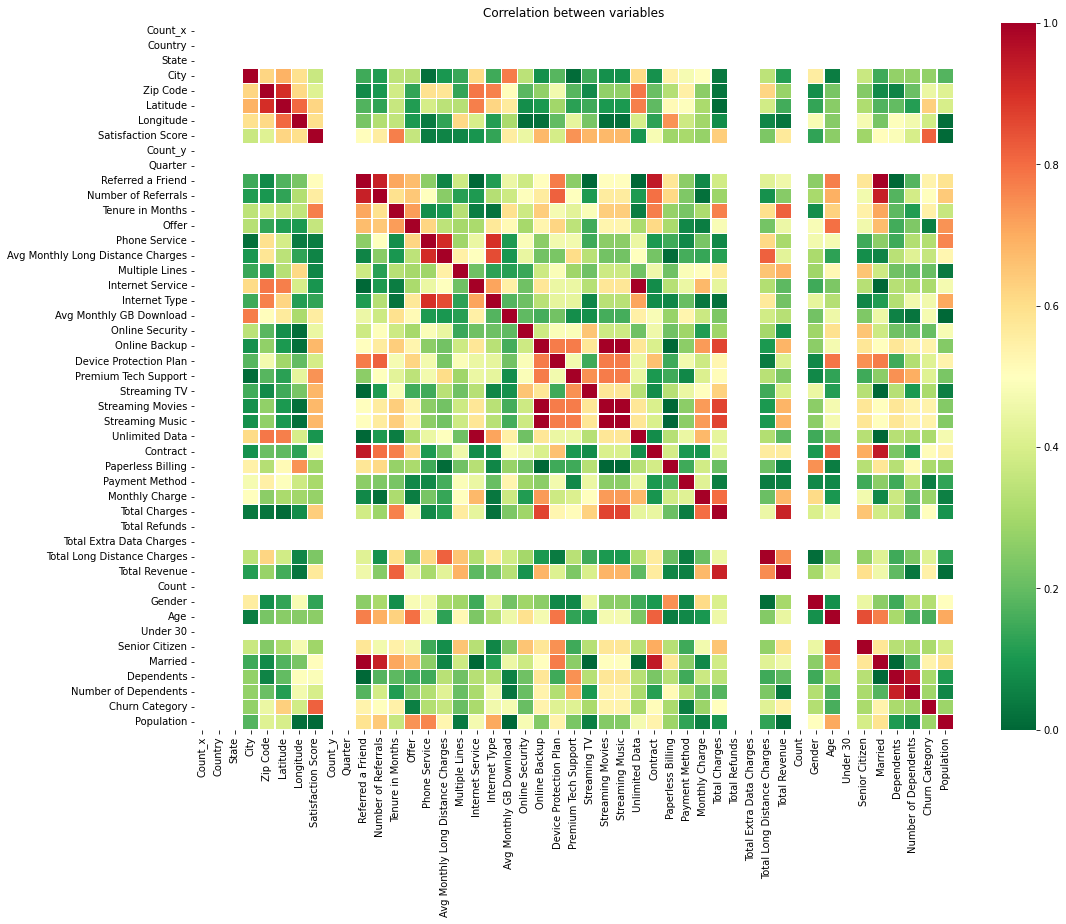

In [114]:
plt.figure(figsize=(17, 13))
full_cor_matrix_copy = full_cor_matrix.copy(deep=True)
full_cor_matrix_copy.dropna()
ax = sns.heatmap(full_cor_matrix_copy, xticklabels=full_cor_matrix_copy.columns, yticklabels=full_cor_matrix_copy.columns, 
                 linewidths=0.2, cmap="RdYlGn_r", fmt="s")

plt.title("Correlation between variables")
plt.show()

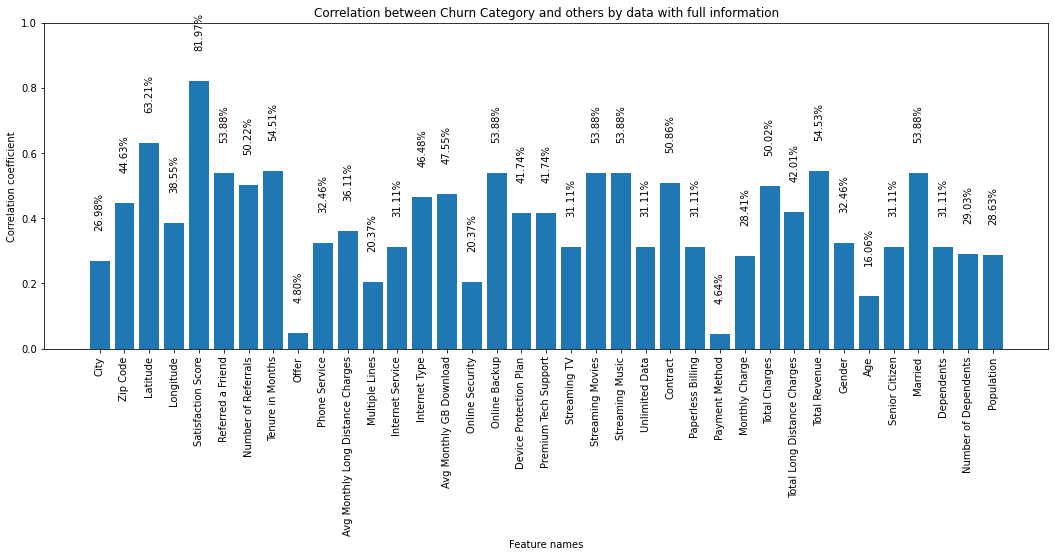

In [115]:
full_x = [index for index, value in full_cor_matrix_copy['Churn Category'].items() if pd.notnull(value)]
full_y = [value for index, value in full_cor_matrix_copy['Churn Category'].items() if pd.notnull(value)]

full_x.remove('Churn Category')
full_y.remove(1)

fig = plt.figure(figsize=(18, 6))
plt.bar(full_x, full_y)
plt.xticks(np.arange(len(full_x)), full_x)
plt.xticks(rotation=90)
plt.xlabel('Feature names')
plt.ylabel('Correlation coefficient')
plt.title('Correlation between Churn Category and others by data with full information')
for i in range(len(full_x)):
    plt.text(full_x[i], full_y[i] + 0.1, '{:.2%}'.format(full_y[i]), ha='center', rotation=90)  

plt.ylim([0, 1])  
plt.show()

In [116]:
# Find the correlation of columns
cor_matrix = result_train_copy.corr().abs()
print(cor_matrix['Churn Category'])

Count_x                                   NaN
Country                                   NaN
State                                     NaN
City                                 0.013355
Zip Code                             0.019834
Latitude                             0.059253
Longitude                            0.038114
Satisfaction Score                   0.337634
Count_y                                   NaN
Quarter                                   NaN
Referred a Friend                    0.050436
Number of Referrals                  0.114960
Tenure in Months                     0.170288
Offer                                0.085079
Phone Service                        0.001216
Avg Monthly Long Distance Charges    0.008377
Multiple Lines                       0.022414
Internet Service                     0.115000
Internet Type                        0.041188
Avg Monthly GB Download              0.051324
Online Security                      0.085729
Online Backup                     

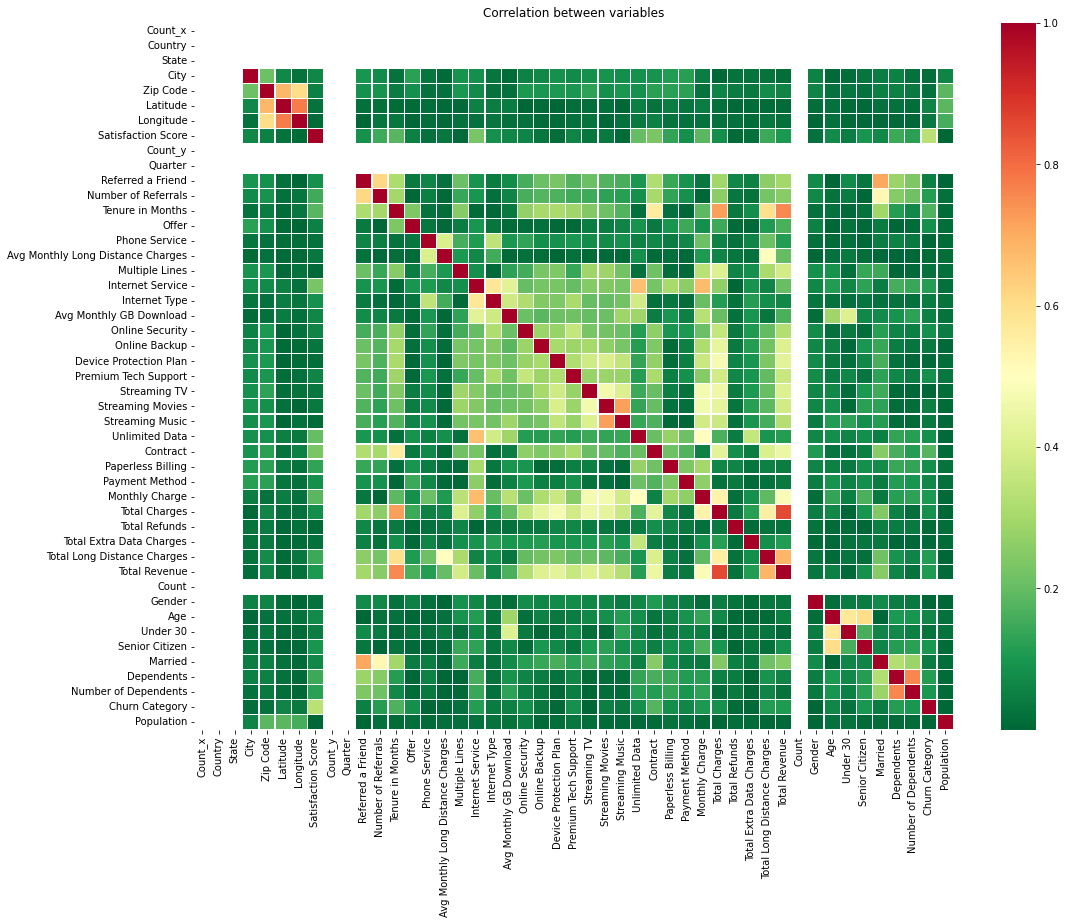

In [117]:
plt.figure(figsize=(17, 13))
cor_matrix_copy = cor_matrix.copy(deep=True)
cor_matrix_copy.dropna()
ax = sns.heatmap(cor_matrix_copy, xticklabels=cor_matrix_copy.columns, yticklabels=cor_matrix_copy.columns, 
                 linewidths=0.2, cmap="RdYlGn_r", fmt="s")

plt.title("Correlation between variables")
plt.show()

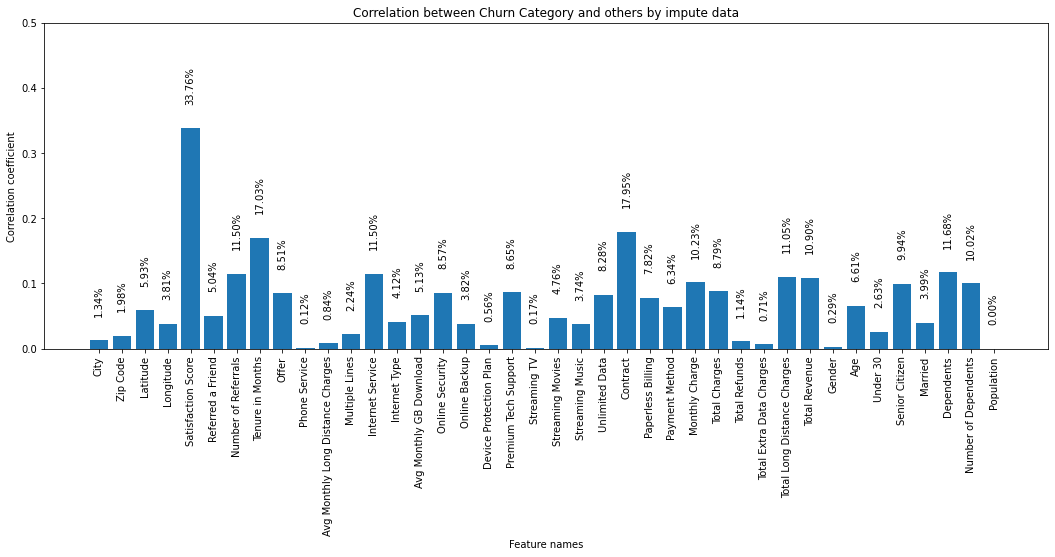

In [118]:
impute_x = [index for index, value in cor_matrix_copy['Churn Category'].items() if pd.notnull(value)]
impute_y = [value for index, value in cor_matrix_copy['Churn Category'].items() if pd.notnull(value)]

impute_x.remove('Churn Category')
impute_y.remove(1)

fig = plt.figure(figsize=(18, 6))
plt.bar(impute_x, impute_y)
plt.xticks(np.arange(len(impute_x)), impute_x)
plt.xticks(rotation=90)
plt.xlabel('Feature names')
plt.ylabel('Correlation coefficient')
plt.title('Correlation between Churn Category and others by impute data')
for i in range(len(impute_x)):
    plt.text(impute_x[i], impute_y[i] + 0.04, '{:.2%}'.format(impute_y[i]), ha='center', rotation=90)  

plt.ylim([0, 0.5])  
plt.show()

In [119]:
useless_feature = [index for index, value in cor_matrix['Churn Category'].items() if value < 0.05 or pd.isnull(value)]
print(useless_feature)

['Count_x', 'Country', 'State', 'City', 'Zip Code', 'Longitude', 'Count_y', 'Quarter', 'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Type', 'Online Backup', 'Device Protection Plan', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Total Refunds', 'Total Extra Data Charges', 'Count', 'Gender', 'Under 30', 'Married', 'Population']


In [120]:
def dropColumns(label):
    global result_train_copy, result_train_miss_copy, result_test_copy, full_info_copy
    result_train_copy = result_train_copy.drop(label, axis=1)
    result_train_miss_copy = result_train_miss_copy.drop(label, axis=1)
    result_test_copy = result_test_copy.drop(label, axis=1)
    full_info_copy = full_info_copy.drop(label, axis=1)

In [121]:
# Throw away the data columns whose correlation to Churn Category is less than 0.05
for item in useless_feature:
    dropColumns(item)

In [122]:
result_train_copy.to_csv('./data/result_after_preprocessing.csv') # Save after preprocessing result to result_after_preprocessing.csv
feature_amount = len(result_train_copy.columns)

print(result_train_copy)
print(result_train_miss_copy)
print(result_test_copy)
print(full_info_copy)

       Latitude  Satisfaction Score  ...  Number of Dependents  Churn Category
0     36.008958                 0.0  ...                   0.0             1.0
1     34.903052                 0.0  ...                   0.0             1.0
2     33.721917                 2.0  ...                   0.0             3.0
3     36.008958                 2.0  ...                   0.0             1.0
4     36.008958                 2.0  ...                   0.0             3.0
...         ...                 ...  ...                   ...             ...
4221  36.008958                 3.0  ...                   0.0             3.0
4222  36.008958                 2.0  ...                   0.0             3.0
4223  36.008958                 3.0  ...                   2.0             3.0
4224  36.008958                 2.0  ...                   3.0             3.0
4225  36.623632                 3.0  ...                   0.0             3.0

[4226 rows x 23 columns]
       Latitude  Satisfact

# **Balance Data**

In [123]:
y_train = result_train_copy['Churn Category'].values
X_train = result_train_copy.drop('Churn Category', axis=1)
full_y_train = full_info_copy['Churn Category'].values
full_X_train = full_info_copy.drop('Churn Category', axis=1)

X_train_miss = result_train_miss_copy.drop('Churn Category', axis=1)

In [124]:
print(f"normal data distribution: {Counter(y_train)}")

# SMOTE
# smo = SMOTE(random_state=seed)
# X_train, y_train = smo.fit_resample(X_train, y_train)

# print(f"SMOTE data distribution: {Counter(y_train)}")

# SVMSMOTE
# ssmo = SVMSMOTE(random_state=seed)
# X_train, y_train = ssmo.fit_resample(X_train, y_train)

# print(f"SVMSMOTE data distribution: {Counter(y_train)}")

# SMOTEN
smn = SMOTEN(random_state=seed)
X_train, y_train = smn.fit_resample(X_train, y_train)

print(f"SMOTEN data distribution: {Counter(y_train)}")

# BorderlineSMOTE
# bsmo = BorderlineSMOTE(random_state=seed)
# X_train, y_train = bsmo.fit_resample(X_train, y_train)

# print(f"BorderlineSMOTE data distribution: {Counter(y_train)}")

# ADASYN
# ada = ADASYN(random_state=seed)
# X_train, y_train = ada.fit_resample(X_train, y_train)

# print(f"ADASYN data distribution: {Counter(y_train)}")

class_weight = dict(Counter(y_train))

normal data distribution: Counter({3.0: 3118, 1.0: 490, 0.0: 201, 2.0: 177, 5.0: 124, 4.0: 116})
SMOTEN data distribution: Counter({1.0: 3118, 3.0: 3118, 2.0: 3118, 4.0: 3118, 5.0: 3118, 0.0: 3118})


# **Split and Standardize Data**

In [125]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

ss = StandardScaler().fit(train_x)
train_x = ss.transform(train_x)
val_x = ss.transform(val_x)
miss_x = ss.transform(X_train_miss)
x_full = ss.transform(full_X_train)

X_test = result_test_copy.drop('Churn Category', axis=1)
X_test_std = ss.transform(X_test)

class_weight = {k: train_x.shape[0] / v for k, v in class_weight.items()}
class_weight = collections.OrderedDict(sorted(class_weight.items()))
print(class_weight)

OrderedDict([(0.0, 4.799871712636305), (1.0, 4.799871712636305), (2.0, 4.799871712636305), (3.0, 4.799871712636305), (4.0, 4.799871712636305), (5.0, 4.799871712636305)])


# **SVM Train**

In [127]:
svm = SVC(kernel='rbf', gamma=0.1, C=10, probability=True, class_weight=class_weight)

start_time = time.time()
model = svm.fit(train_x, train_y)
end_time = time.time()

print(f'Training use {round(end_time - start_time, 3)}s')

Training use 60.118s


In [128]:
y_train_predict = svm.predict(train_x)
Ein = np.mean(np.array(y_train_predict) != train_y)
F1in = metrics.f1_score(train_y, y_train_predict, average='macro')  
print(f'Ein = {round(Ein, 5)}')
print(f'F1_in = {round(F1in, 5)}')

y_val_predict = svm.predict(val_x)
Eval = np.mean(np.array(y_val_predict) != val_y)
F1val = metrics.f1_score(val_y, y_val_predict, average='macro')  
print(f'Eval = {round(Eval, 5)}')
print(f'F1_val = {round(F1val, 5)}')

Ein = 0.16999
F1_in = 0.84274
Eval = 0.21352
F1_val = 0.79644


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}


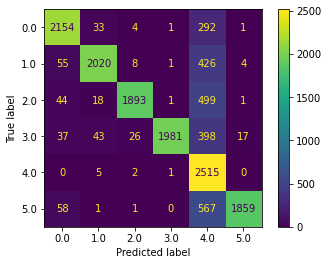

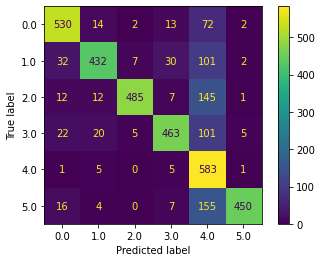

In [129]:
plot_confusion_matrix(model, train_x, train_y)
plot_confusion_matrix(model, val_x, val_y)
print(encoder_map)

In [130]:
print(classification_report(train_y, y_train_predict))
print(classification_report(val_y, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89      2485
         1.0       0.95      0.80      0.87      2514
         2.0       0.98      0.77      0.86      2456
         3.0       1.00      0.79      0.88      2502
         4.0       0.54      1.00      0.70      2523
         5.0       0.99      0.75      0.85      2486

    accuracy                           0.83     14966
   macro avg       0.90      0.83      0.84     14966
weighted avg       0.89      0.83      0.84     14966

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       633
         1.0       0.89      0.72      0.79       604
         2.0       0.97      0.73      0.84       662
         3.0       0.88      0.75      0.81       616
         4.0       0.50      0.98      0.67       595
         5.0       0.98      0.71      0.82       632

    accuracy                           0.79      3742
   macro avg       0.85

# **SVM Test**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}


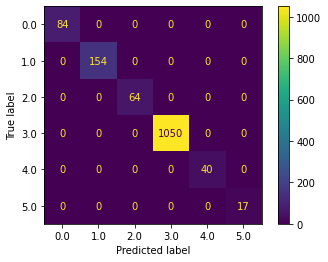

In [131]:
y_test = svm.predict(X_test_std)
plot_confusion_matrix(model, X_test_std, y_test)
print(encoder_map)

In [132]:
svm_submit_result = './svm_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(svm_submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(y_test[i])])
        f.write(f'{id},{pred}\n')

In [133]:
from google.colab import files

files.download(svm_submit_result)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **SVM Interpretability**

In [134]:
feature_names = result_train_copy.drop('Churn Category', axis=1).columns
class_names = [k for k, v in encoder_map.items()]

print(f'Test id : 0454-OKRCT')
print(f'Predicted class is {class_names[int(svm.predict(x_full[0].reshape(1,-1))[0])]}')
print(f'True class is {class_names[int(full_y_train[0])]}')

explainer = lime_tabular.LimeTabularExplainer(train_x, mode="classification", feature_names=feature_names)

Test id : 0454-OKRCT
Predicted class is No Churn
True class is No Churn


In [136]:
print(encoder_map)
print()

exp = explainer.explain_instance(x_full[0], svm.predict_proba, num_features=len(feature_names), top_labels=2)
exp.show_in_notebook()

{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}



# **Deep Neural Network Train**

In [137]:
class IBMDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

In [138]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(feature_amount - 1, 256)
        self.layer2 = nn.Linear(256, 64)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64)
        self.out = nn.Linear(64, 6)
        self.dp = nn.Dropout(0.1)
        self.act_fn = nn.LeakyReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)
        x = self.bn1(x)
        x = self.dp(x)

        x = self.layer2(x)
        x = self.act_fn(x)
        x = self.bn2(x)
        x = self.dp(x)
        
        x = self.out(x)
        
        return x

# classifier = Classifier()
# summary(classifier, X_train.shape, device="cpu")

In [139]:
def get_pseudo_labels(dataset, model, batch_size, threshold=0.95):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    softmax = nn.Softmax(dim=-1)

    pseudo_x = []
    pseudo_y = []
    for i, data in enumerate(data_loader):
        inputs = data

        with torch.no_grad():
            logits = model(inputs.to(device))

        probs = softmax(logits)
        label = torch.where(torch.max(probs, dim=1)[0] > threshold, torch.argmax(probs,dim=1), -1)
        label = label.cpu()
        for j in range(len(label)):
            if label[j] != -1:
                pseudo_x.append(data[j])
                pseudo_y.append(label[j])

    model.train()
    print(f"Pseudo Labeling : {len(pseudo_x)}")
    if len(pseudo_x) > 0:
        flag = 1
        pseudo_dataset = IBMDataset(torch.stack(pseudo_x, dim=0).numpy(), np.array(pseudo_y))
        return pseudo_dataset, len(pseudo_x), flag
    else:
        flag = 0
        return None, 0, flag
    

In [140]:
print('Size of training set: {}'.format(train_x.shape))
print('Size of training set: {}'.format(miss_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (14966, 22)
Size of training set: (1408, 22)
Size of validation set: (3742, 22)


In [141]:
BATCH_SIZE = 64

train_set = IBMDataset(train_x, train_y)
miss_set = IBMDataset(miss_x, None)
val_set = IBMDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [142]:
# get device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

# training parameters
num_epoch = 3000             # number of training epoch
learning_rate = 0.001       # learning rate
callback_num = 300

# the path where checkpoint saved
model_path = './best_model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
dnn_class_weight = [v for k, v in class_weight.items()]
# dnn_class_weight = [1 - (x / sum(dnn_class_weight)) for x in dnn_class_weight]
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(dnn_class_weight).to(device))
optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4, lr=learning_rate)
scheduler = StepLR(optimizer, step_size=len(train_loader) * 200, gamma=0.1)

DEVICE: cuda


In [143]:
best_acc = 0.0
count = 0
start_time = time.time()
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # Pseudo Label
    pseudo_set, add_num, flag = get_pseudo_labels(miss_set, model, BATCH_SIZE)
    if flag:
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader_semi = DataLoader(concat_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    else:
        train_loader_semi = train_loader
    
    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader_semi):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() 
        optimizer.step()
        scheduler.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/(len(train_set) + add_num), train_loss/len(train_loader_semi), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # Record Training and validation info
            train_acc_list.append(train_acc/(len(train_set) + add_num))
            train_loss_list.append(train_loss/len(train_loader_semi))
            val_acc_list.append(val_acc/len(val_set))
            val_loss_list.append(val_loss/len(val_loader))

            # if the model improves, save a checkpoint at this epoch
            count += 1
            if val_acc > best_acc:
                count = 0
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/(len(train_set) + add_num), train_loss/len(train_loader_semi)
        ))

    if count > callback_num:
        break

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')

end_time = time.time()

Pseudo Labeling : 0
[001/3000] Train Acc: 0.523854 Loss: 1.211435 | Val Acc: 0.635756 loss: 0.990386
saving model with acc 0.636
Pseudo Labeling : 635
[002/3000] Train Acc: 0.640600 Loss: 0.929197 | Val Acc: 0.690273 loss: 0.848690
saving model with acc 0.690
Pseudo Labeling : 676
[003/3000] Train Acc: 0.686421 Loss: 0.824008 | Val Acc: 0.711652 loss: 0.765320
saving model with acc 0.712
Pseudo Labeling : 711
[004/3000] Train Acc: 0.706959 Loss: 0.752463 | Val Acc: 0.737306 loss: 0.705224
saving model with acc 0.737
Pseudo Labeling : 708
[005/3000] Train Acc: 0.719025 Loss: 0.721618 | Val Acc: 0.745858 loss: 0.678144
saving model with acc 0.746
Pseudo Labeling : 734
[006/3000] Train Acc: 0.733885 Loss: 0.682705 | Val Acc: 0.756547 loss: 0.657037
saving model with acc 0.757
Pseudo Labeling : 701
[007/3000] Train Acc: 0.738623 Loss: 0.663408 | Val Acc: 0.761892 loss: 0.634991
saving model with acc 0.762
Pseudo Labeling : 758
[008/3000] Train Acc: 0.746248 Loss: 0.639194 | Val Acc: 0.7664

In [144]:
print(f'Training use {round(end_time - start_time, 3)}s')

Training use 409.053s


In [145]:
def plot_learning_curve(train_record, valid_record, title=''):
    total_steps = len(train_record)
    x = range(total_steps)
    plt.figure(figsize=(6, 4))
    plt.plot(x, train_record, c='tab:red', label='train')
    plt.plot(x, valid_record, c='tab:cyan', label='valid')
    plt.ylim(0.0, max(valid_record) + 1)
    plt.xlabel('Training epoch')
    plt.ylabel(title)
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

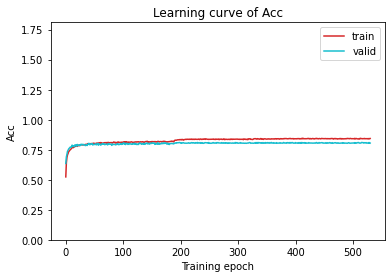

In [146]:
plot_learning_curve(train_acc_list, val_acc_list, 'Acc')

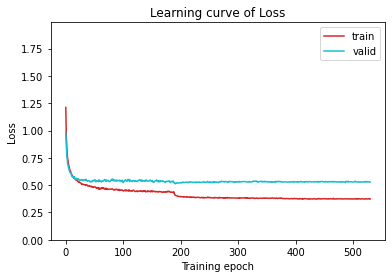

In [147]:
plot_learning_curve(train_loss_list, val_loss_list, 'Loss')

In [148]:
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval() # set the model to evaluation mode
train_predict = []
train_ground_truth = []
err = 0
for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    k = 0
    for y in test_pred.cpu().numpy():
        train_predict.append(y)
        train_ground_truth.append(labels.cpu().numpy()[k])
        k += 1

Ein = np.mean(np.array(train_predict) != np.array(train_ground_truth))
F1in = metrics.f1_score(train_ground_truth, train_predict, average='macro')  
print(f'Ein = {round(Ein, 5)}')
print(f'F1_in = {round(F1in, 5)}')

val_predict = []
val_ground_truth = []
for i, data in enumerate(val_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    k = 0
    for y in test_pred.cpu().numpy():
        val_predict.append(y)
        val_ground_truth.append(labels.cpu().numpy()[k])
        k += 1

Eval = np.mean(np.array(val_predict) != val_ground_truth)
F1val = metrics.f1_score(val_ground_truth, val_predict, average='macro')  
print(f'Eval = {round(Eval, 5)}')
print(f'F1_val = {round(F1val, 5)}')

Ein = 0.16103
F1_in = 0.8511
Eval = 0.18947
F1_val = 0.82083


# **Deep Neural Network Test**

In [149]:
# create testing dataset
test_set = IBMDataset(X_test_std, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [150]:
predict = []
model.eval() # set the model to evaluation mode
for i, data in enumerate(test_loader):
    inputs = data
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    for y in test_pred.cpu().numpy():
        predict.append(y)

print(encoder_map)
print(np.bincount(predict))

{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}
[  60  230   51 1001   24   43]


In [151]:
dnn_submit_result = './dnn_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(dnn_submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(predict[i])])
        f.write(f'{id},{pred}\n')

In [152]:
from google.colab import files

files.download(dnn_submit_result)
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Deep Neural Network Interpretability**

In [163]:
model.eval()
test_case = torch.FloatTensor([x_full[0]]).to(device)
print('Test id : 0454-OKRCT')
print(f'Predicted class is {class_names[torch.argmax(model(test_case)).cpu().numpy()]}')
print(f'True class is {class_names[int(full_y_train[0])]}')

explainer = lime_tabular.LimeTabularExplainer(train_x, mode="classification", feature_names=feature_names)

Test id : 0454-OKRCT
Predicted class is No Churn
True class is No Churn


In [164]:
print(encoder_map)
print()

def probs(data):
    model.eval()
    data = torch.FloatTensor(data).to(device)
    logits = model(data)
    softmax = nn.Softmax(dim=-1)
    probs = softmax(logits)

    return probs.detach().cpu().numpy()

exp = explainer.explain_instance(x_full[0], probs, num_features=len(feature_names), top_labels=2)
exp.show_in_notebook()

del model

{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}



# **XGBoost Train**

In [155]:
classifier = XGBClassifier(
    learning_rate =0.3,
    n_estimators=100,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.5,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    use_label_encoder =False,
    eval_metric='mlogloss') 

In [156]:
start_time = time.time()
xgmodel = classifier.fit(train_x, train_y)
end_time = time.time()

train_predict = xgmodel.predict(train_x)
val_predict = xgmodel.predict(val_x)

In [157]:
print(f'Training use {round(end_time - start_time, 3)}s')

Training use 15.698s


In [158]:
Ein = np.mean(np.array(train_predict) != train_y)
F1in = metrics.f1_score(train_y, train_predict, average='macro')  
print(f'Ein = {round(Ein, 5)}')
print(f'F1_in = {round(F1in, 5)}')
print('XGBoost Train Score {}'.format(xgmodel.score(train_x, train_y)))
print()

Eval = np.mean(np.array(val_predict) != val_y)
F1val = metrics.f1_score(val_y, val_predict, average='macro')  
print(f'Eval = {round(Eval, 5)}')
print(f'F1_val = {round(F1val, 5)}')
print('XGBoost Valid Score {}'.format(xgmodel.score(val_x, val_y)))

Ein = 0.14486
F1_in = 0.86691
XGBoost Train Score 0.8551383135106241

Eval = 0.17424
F1_val = 0.83571
XGBoost Valid Score 0.8257616247995724


# **XGBoost Test**

In [159]:
predict = xgmodel.predict(X_test_std)
predict = np.array(predict, dtype=np.int64)

print(encoder_map)
print(np.bincount(predict))

{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}
[  42  213   38 1049   36   31]


In [160]:
xgboost_submit_result = './xgboost_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(xgboost_submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(predict[i])])
        f.write(f'{id},{pred}\n')

In [161]:
from google.colab import files

files.download(xgboost_submit_result)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **XGBoost Interpretability**

In [165]:
print('Test id : 0454-OKRCT')
print(f'Predicted class is {class_names[int(xgmodel.predict(x_full[0].reshape(1,-1))[0])]}')
print(f'True class is {class_names[int(full_y_train[0])]}')

explainer = lime_tabular.LimeTabularExplainer(train_x, mode="classification", feature_names=feature_names)

Test id : 0454-OKRCT
Predicted class is No Churn
True class is No Churn


In [166]:
print(encoder_map)
print()

exp = explainer.explain_instance(x_full[0], xgmodel.predict_proba, num_features=len(feature_names), top_labels=2)
exp.show_in_notebook()

{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}



# **Test Data Analysis**

In [167]:
svm_test = pd.read_csv(svm_submit_result)
dnn_test = pd.read_csv(dnn_submit_result)
xgboost_test = pd.read_csv(xgboost_submit_result)

In [168]:
def plotResult(dataset1, dataset2, dataset3, method):
    fig, ax = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle('Test Data Statistics')

    counts = []
    iter = 0
    for dataset in [dataset1, dataset2, dataset3]:
        freq = dataset.groupby('Churn Category').size()
        print(f'====== {method[iter]} ======')
        print(freq)
        print()

        counts = [count for _, count in freq.items()]
        x = np.arange(len(counts))
        ax[iter].bar(x, counts)
        ax[iter].set_xticks([0, 1, 2, 3, 4, 5])
        ax[iter].set_xticklabels(['No Churn', 'Competitor', 'Dissatisfaction', 'Attitude', 'Price', 'Other'], rotation=90)
        ax[iter].set_title(f'{method[iter]}')
        iter += 1

    plt.show()

====== SVM ======
Churn Category
0    1050
1     154
2      64
3      84
4      17
5      40
dtype: int64

====== DNN ======
Churn Category
0    1001
1     230
2      51
3      60
4      43
5      24
dtype: int64

====== XGBoost ======
Churn Category
0    1049
1     213
2      38
3      42
4      31
5      36
dtype: int64



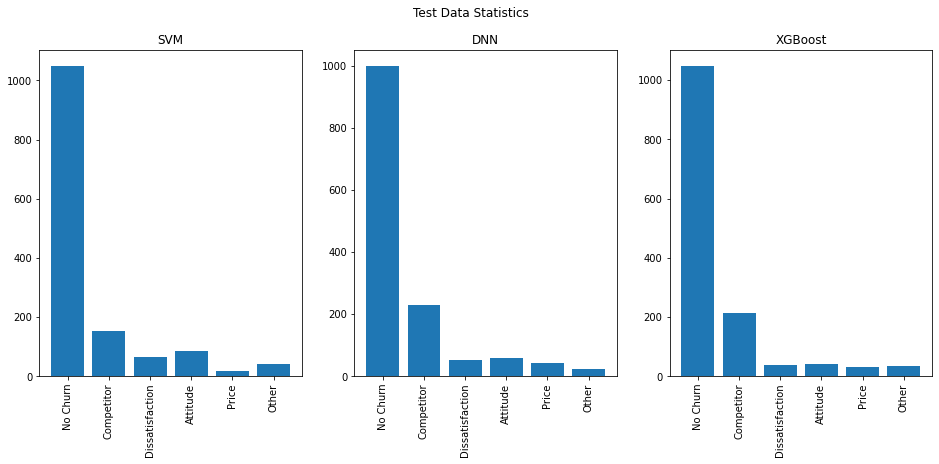

In [169]:
plotResult(svm_test, dnn_test, xgboost_test, ['SVM', 'DNN', 'XGBoost'])